In [1]:
import pandas as pd

# Load the forecasted data
data = pd.read_csv('tesla_bnd_spy_combined_forecasted_data.csv')

# Display the first few rows to inspect the data
data.head()

,Date,BND_Adj Close,SPY_Adj Close,TSLA_Adj Close,BND_Close,SPY_Close,TSLA_Close,BND_High,SPY_High,TSLA_High,...,TSLA_Low,BND_Open,SPY_Open,TSLA_Open,BND_Volume,SPY_Volume,TSLA_Volume,TSLA_Forecast,BND_Forecast,SPY_Forecast
0,2015-01-02 00:00:00+00:00,63.358761,173.173767,14.620667,82.650002,205.429993,14.620667,82.690002,206.880005,14.883333,...,14.217333,82.430000,206.380005,14.858000,2218800.0,121465900.0,71466000.0,NaN,NaN,NaN
1,2015-01-05 00:00:00+00:00,63.542751,170.046295,14.006000,82.889999,201.720001,14.006000,82.919998,204.369995,14.433333,...,13.810667,82.739998,204.169998,14.303333,5820100.0,169632600.0,80527500.0,NaN,NaN,NaN
2,2015-01-06 00:00:00+00:00,63.726738,168.444611,14.085333,83.129997,199.820007,14.085333,83.379997,202.720001,14.280000,...,13.614000,83.029999,202.089996,14.004000,3887600.0,209151400.0,93928500.0,NaN,NaN,NaN
3,2015-01-07 00:00:00+00:00,63.765091,170.543655,14.063333,83.180000,202.309998,14.063333,83.279999,202.720001,14.318667,...,13.985333,83.139999,201.419998,14.223333,2433400.0,125346700.0,44526000.0,NaN,NaN,NaN
4,2015-01-08 00:00:00+00:00,63.665394,173.569977,14.041333,83.050003,205.899994,14.041333,83.110001,206.160004,14.253333,...,14.000667,83.110001,204.009995,14.187333,1873400.0,147217800.0,51637500.0,NaN,NaN,NaN


In [2]:
# Calculate daily returns for each asset
data['TSLA_Return'] = data['TSLA_Forecast'].pct_change()
data['BND_Return'] = data['BND_Forecast'].pct_change()
data['SPY_Return'] = data['SPY_Forecast'].pct_change()

# Annualize the returns by multiplying the daily returns by the number of trading days in a year (252)
annual_return_tsla = data['TSLA_Return'].mean() * 252
annual_return_bnd = data['BND_Return'].mean() * 252
annual_return_spy = data['SPY_Return'].mean() * 252

print(f"Annual Returns:\nTSLA: {annual_return_tsla:.2f}\nBND: {annual_return_bnd:.2f}\nSPY: {annual_return_spy:.2f}")

Annual Returns:
TSLA: 81.24
BND: 132.43
SPY: 663.38


In [3]:
# Compute the covariance matrix
cov_matrix = data[['TSLA_Return', 'BND_Return', 'SPY_Return']].cov()

print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
             TSLA_Return  BND_Return  SPY_Return
TSLA_Return     1.456591   -0.229219   -0.677953
BND_Return     -0.229219    2.568629    3.763975
SPY_Return     -0.677953    3.763975  111.303264


In [4]:
import numpy as np
from scipy.optimize import minimize

# Set up the number of assets
assets = ['TSLA', 'BND', 'SPY']
returns = np.array([annual_return_tsla, annual_return_bnd, annual_return_spy])
cov_matrix = cov_matrix.to_numpy()

# Function to calculate portfolio performance (return and volatility)
def portfolio_performance(weights, mean_returns, cov_matrix):
    # Portfolio return
    portfolio_return = np.sum(weights * mean_returns)
    # Portfolio volatility (standard deviation)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Function to calculate Sharpe ratio (assuming risk-free rate is 0)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -portfolio_return / portfolio_volatility  

# Constraints: the sum of weights should be 1
def check_sum(weights):
    return np.sum(weights) - 1

# Initial guess for the portfolio weights (equal weights for simplicity)
initial_weights = np.array([1/3, 1/3, 1/3])

# Bounds for the weights (between 0 and 1 for each asset)
bounds = ((0, 1), (0, 1), (0, 1))

# Optimization process
result = minimize(negative_sharpe_ratio, initial_weights, args=(returns, cov_matrix), 
                  method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': check_sum})

# Optimized portfolio weights
optimized_weights = result.x

# Calculate the optimized portfolio performance
optimized_return, optimized_volatility = portfolio_performance(optimized_weights, returns, cov_matrix)

print(f"Optimized Portfolio Weights:\nTSLA: {optimized_weights[0]:.2f}\nBND: {optimized_weights[1]:.2f}\nSPY: {optimized_weights[2]:.2f}")
print(f"Optimized Portfolio Return: {optimized_return:.2f}")
print(f"Optimized Portfolio Volatility: {optimized_volatility:.2f}")

Optimized Portfolio Weights:
TSLA: 0.54
BND: 0.42
SPY: 0.04
Optimized Portfolio Return: 124.96
Optimized Portfolio Volatility: 1.02


In [5]:
# Portfolio's average return
portfolio_return = np.sum(optimized_weights * returns)

# Portfolio's standard deviation (volatility)
portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))

# Calculate the Value at Risk (VaR) at a 95% confidence level
confidence_level = 0.95
VaR = np.percentile(np.random.normal(portfolio_return, portfolio_volatility, 10000), 100 * (1 - confidence_level))

print(f"Portfolio Return: {portfolio_return:.2f}")
print(f"Portfolio Volatility: {portfolio_volatility:.2f}")
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {VaR:.2f}")

Portfolio Return: 124.96
Portfolio Volatility: 1.02
Value at Risk (VaR) at 95.0% confidence level: 123.27


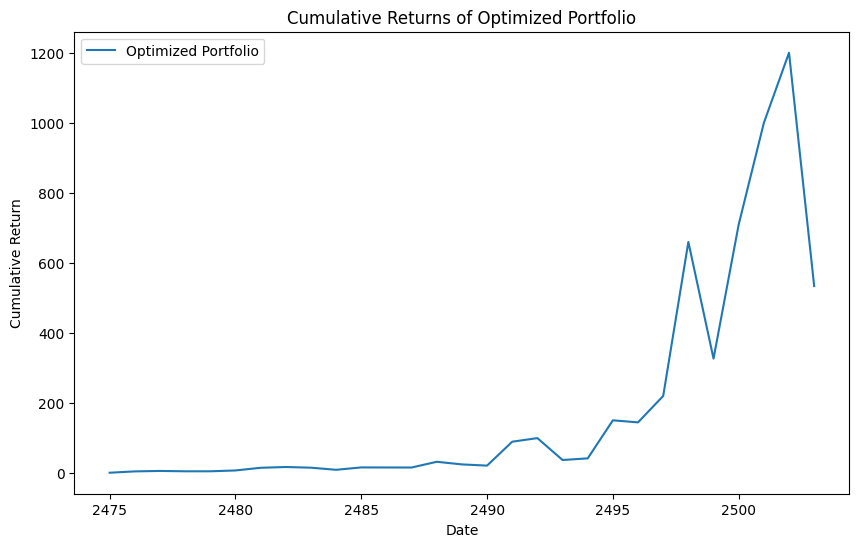

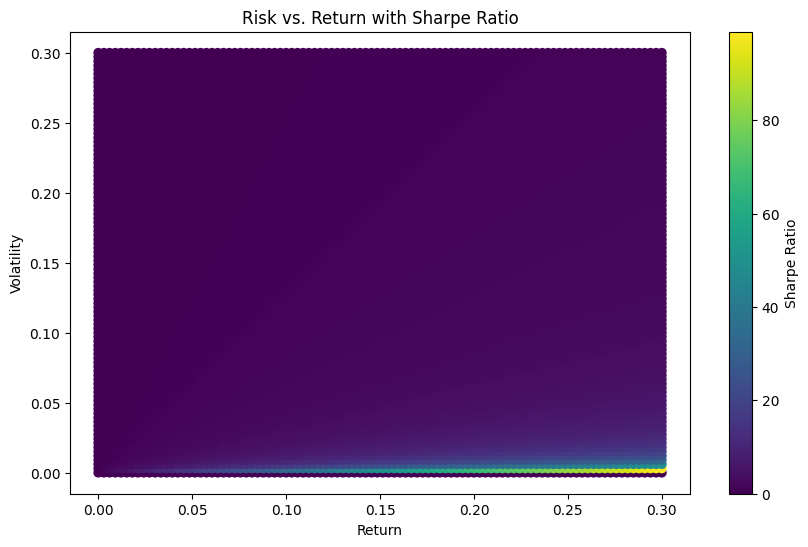

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have 'optimized_weights' and 'data' with columns 'TSLA_Return', 'BND_Return', 'SPY_Return'

# Simulate cumulative returns of the portfolio
portfolio_returns = data['TSLA_Return'] * optimized_weights[0] + data['BND_Return'] * optimized_weights[1] + data['SPY_Return'] * optimized_weights[2]
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Optimized Portfolio")
plt.title("Cumulative Returns of Optimized Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# Generate ranges for return and volatility
returns_range = np.linspace(0, 0.3, 100)
volatility_range = np.linspace(0, 0.3, 100)

# Create a meshgrid of returns and volatilities
return_grid, volatility_grid = np.meshgrid(returns_range, volatility_range)

# Flatten the grids to create 1D arrays
return_values = return_grid.flatten()
volatility_values = volatility_grid.flatten()

# Calculate Sharpe ratios using vectorized operations
sharpe_ratios = np.divide(return_values, volatility_values, out=np.zeros_like(return_values), where=volatility_values != 0)

# Plot Risk vs Return with Sharpe Ratio
plt.figure(figsize=(10, 6))
scatter = plt.scatter(return_values, volatility_values, c=sharpe_ratios, cmap='viridis')
plt.title("Risk vs. Return with Sharpe Ratio")
plt.xlabel("Return")
plt.ylabel("Volatility")
plt.colorbar(scatter, label="Sharpe Ratio")
plt.show()